In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

%matplotlib inline

In this project paper we analyse dataset with user reviews and ratings 
of a few major tech companies. The dataset is using Glassdoor data and 
was available on Kaggle (not anymore).

In [77]:
df = pd.read_csv('employee_reviews.csv')

### general description

The dataset has around 67K rows and 17 columns. We're primarily interested in predicting `overall-ratings` (on the scale 1-5) using `summary` (initially) and `pros`, `cons` (maybe later).

In [78]:
df.shape

(67529, 17)

In [79]:
df.head()

,review-number,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


### companies: number of reviews and their ratings

Here are some major observations:
- First of all there are `6` companies in this dataset. 
- We have a lot of reviews of `Amazon` and not so much for `Facebook` and `Netflix`.
- Average rating is lowest for `Netflix` and `Amazon`, highest for `Facebook` as expected. This fact is also illustrated by a heatmap below. We may see, for example, that more than 70% of Facebook's ratings is 5.0.
- In general the average rating is quite high so we may expect that number of positive reviews (4, 5) is much bigger that number of negative ones (1, 2). And this is indeed the case. Probably we should try to reduce this imbalance.

In [80]:
df.company.unique()

array(['google', 'amazon', 'facebook', 'netflix', 'apple', 'microsoft'],
      dtype=object)

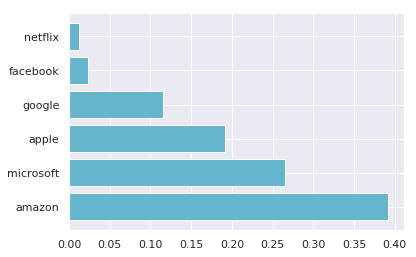

In [124]:
company_shares_dic = {}
total = df.shape[0]
for c in df.company.unique():
    company_shares_dic[c] = df[df.company == c].shape[0] / total

company_shares_list = sorted(list(company_shares_dic.items()), 
                             key=lambda x: x[1], reverse=True)
x, y = zip(*company_shares_list)
plt.barh(x, y, color='c');

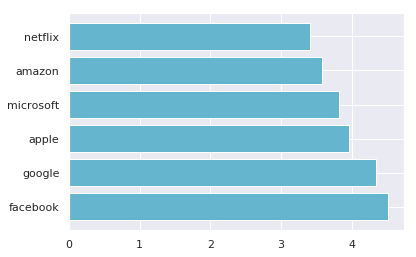

In [82]:
avg_rating_dict = dict(df.groupby('company')['overall-ratings'].mean())
avg_rating_list = sorted(list(avg_rating_dict.items()), 
                             key=lambda x: x[1], reverse=True)
x, y = zip(*avg_rating_list)
plt.barh(x, y, color='c');

In [83]:
neg_ratings = (df[df['overall-ratings'] == 1].shape[0] + \
              df[df['overall-ratings'] == 2].shape[0]) / total
pos_ratings = (df[df['overall-ratings'] == 4].shape[0] + \
              df[df['overall-ratings'] == 5].shape[0]) / total
print(f'neg_ratings:{neg_ratings*100:.1f}%, pos_ratings:{pos_ratings*100:.1f}%')

neg_ratings:13.6%, pos_ratings:67.7%


In [129]:
df_ratings = df.groupby(['company', 'overall-ratings'])['review-number'].count().unstack()
df_ratings = df_ratings.div(df_ratings.sum(axis=1), axis=0)
df_ratings

overall-ratings,1.0,2.0,3.0,4.0,5.0
company,,,,,
amazon,0.093114,0.104086,0.210897,0.306129,0.285774
apple,0.037375,0.062857,0.174981,0.353745,0.371042
facebook,0.029560,0.030818,0.061635,0.154088,0.723899
google,0.019824,0.031718,0.097583,0.290958,0.559918
microsoft,0.035639,0.072950,0.212995,0.396040,0.282376
netflix,0.148148,0.138272,0.164198,0.253086,0.296296


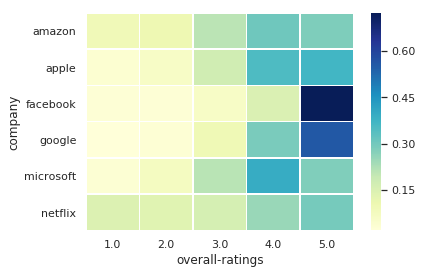

In [127]:
sns.heatmap(df_ratings, linewidths=.5, cmap="YlGnBu");

### data preparation

Here we just remove all columns that we don't need (see above) and write df into the new file. 

Let's also add simplified rating (and remove rows with rating `3.0`: 
- `0` for 1, 2;
- `1` for 4, 5;

In [145]:
columns_to_explore = ['summary', 'pros', 'cons', 'overall-ratings']
df_to_explore = df[columns_to_explore]
df_to_explore.head()

,summary,pros,cons,overall-ratings
0,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,5.0
1,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,4.0
2,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",5.0
3,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,5.0
4,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",5.0


In [132]:
df_to_explore.to_csv('employee_reviews_to_explore.csv', index=False)

In [135]:
!head employee_reviews_to_explore.csv | cut -c -80

summary,pros,cons,overall-ratings
Best Company to work for,People are smart and friendly,Bureaucracy is slowing th
"Moving at the speed of light, burn out is inevitable","1) Food, food, food. 15+
"Great balance between big-company security and fun, fast-moving projects","* If
The best place I've worked and also the most demanding.,"You can't find a more w
"Unique, one of a kind dream job","Google is a world of its own. At every other 
NICE working in GOOGLE as an INTERN,"People are not that busy, so they are nice 
Software engineer,Great working environment. Good work life balance,Usual big co
great place to work and progress,"work culture, benefits, growth, people,",No co
Google Surpasses Realistic Expectations,"Great products. Vision you can feel goo


In [146]:
import numpy as np
df_to_explore_simple = df_to_explore.copy()
def simplify_rating(rating):
    if rating == 4. or rating == 5.:
        return 1
    elif rating == 1. or rating == 2.:
        return 0
    else:
        return -1
df_to_explore_simple['simple_ratings'] = np.vectorize(simplify_rating)(
                                      df_to_explore_simple['overall-ratings'])

In [152]:
df_to_explore_simple.shape, \
df_to_explore_simple[df_to_explore_simple['simple_ratings'] >= 0].shape, \
df_to_explore_simple[df_to_explore_simple['simple_ratings'] < 0].shape \

((67529, 5), (54876, 5), (12653, 5))

In [154]:
df_to_explore_simple  = df_to_explore_simple[df_to_explore_simple['simple_ratings'] != -1]
df_to_explore_simple.shape

(54876, 5)

In [155]:
df_to_explore_simple.to_csv('employee_reviews_to_explore_simple.csv', index=False)